In [61]:
import requests
import pandas as pd
import time
from io import StringIO  # Import StringIO from io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [2]:
# Base URL for the API
base_url = "https://data.austintexas.gov/resource/9t4d-g238.csv"

# Parameters for pagination
limit = 1000
offset = 0
all_data = []

# Function to get data with offset
def get_data(offset):
    params = {
        "$limit": limit,
        "$offset": offset
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        print(f"Data retrieved with offset: {offset}")
        # Use StringIO from io module
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to retrieve data for offset: {offset}")
        return pd.DataFrame()

# Loop through the dataset using pagination
while True:
    # Get data for the current offset
    df = get_data(offset)

    # Break if no more data is returned
    if df.empty:
        print("No more data to retrieve.")
        break

    # Append the data to the list
    all_data.append(df)

    # Increment the offset for the next request
    offset += limit

    # Sleep to avoid hitting the API rate limit
    time.sleep(1)

# Combine all pages into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)

# Display the combined DataFrame
print(f"\nFinal DataFrame Shape: {final_df.shape}")
print(final_df.head())

Data retrieved with offset: 0
Data retrieved with offset: 1000
Data retrieved with offset: 2000
Data retrieved with offset: 3000
Data retrieved with offset: 4000
Data retrieved with offset: 5000
Data retrieved with offset: 6000
Data retrieved with offset: 7000
Data retrieved with offset: 8000
Data retrieved with offset: 9000
Data retrieved with offset: 10000
Data retrieved with offset: 11000
Data retrieved with offset: 12000
Data retrieved with offset: 13000
Data retrieved with offset: 14000
Data retrieved with offset: 15000
Data retrieved with offset: 16000
Data retrieved with offset: 17000
Data retrieved with offset: 18000
Data retrieved with offset: 19000
Data retrieved with offset: 20000
Data retrieved with offset: 21000
Data retrieved with offset: 22000
Data retrieved with offset: 23000
Data retrieved with offset: 24000
Data retrieved with offset: 25000
Data retrieved with offset: 26000
Data retrieved with offset: 27000
Data retrieved with offset: 28000
Data retrieved with offset:

# **Data Dictionary for Austin Animal Center Outcomes Dataset**

| Column Name         | Description                                                  | API Field Name      | Data Type           |
|---------------------|--------------------------------------------------------------|---------------------|---------------------|
| **Animal ID**       | Unique identifier for each animal                            | `animal_id`         | Text                |
| **Name**            | Name of the animal (if available)                             | `name`              | Text                |
| **DateTime**        | Date and time of the outcome event                            | `datetime`          | Floating Timestamp  |
| **MonthYear**       | Month and year of the outcome event                           | `monthyear`         | Floating Timestamp  |
| **Date of Birth**   | Date of birth of the animal                                   | `date_of_birth`     | Floating Timestamp  |
| **Outcome Type**    | General category of outcome (e.g., Adoption, Transfer, Euthanasia) | `outcome_type` | Text                |
| **Outcome Subtype** | Specific subtype of outcome (e.g., Offsite, Foster)            | `outcome_subtype`   | Text                |
| **Animal Type**     | Type of animal (e.g., Dog, Cat)                               | `animal_type`       | Text                |
| **Sex upon Outcome**| Sex and reproductive status upon outcome (e.g., Neutered Male) | `sex_upon_outcome`  | Text                |
| **Age upon Outcome**| Age of the animal at the time of outcome                      | `age_upon_outcome`  | Text                |
| **Breed**           | Breed of the animal                                            | `breed`             | Text                |
| **Color**           | Color description of the animal                               | `color`             | Text                |


# **EDA and Feature Engineering**

In [3]:
final_df.head()

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
0,A882831,*Hamilton,2023-07-01T18:12:00.000,2023-07-01T18:12:00.000,2023-03-25T00:00:00.000,Adoption,NaN,Cat,Neutered Male,3 months,Domestic Shorthair Mix,Black/White
1,A794011,Chunk,2019-05-08T18:20:00.000,2019-05-08T18:20:00.000,2017-05-02T00:00:00.000,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
2,A776359,Gizmo,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,2017-07-12T00:00:00.000,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
3,A821648,NaN,2020-08-16T11:38:00.000,2020-08-16T11:38:00.000,2019-08-16T00:00:00.000,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
4,A720371,Moose,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,2015-10-08T00:00:00.000,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff


In [4]:
data = final_df.copy()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171795 entries, 0 to 171794
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         171795 non-null  object
 1   name              122637 non-null  object
 2   datetime          171795 non-null  object
 3   monthyear         171795 non-null  object
 4   date_of_birth     171795 non-null  object
 5   outcome_type      171753 non-null  object
 6   outcome_subtype   78709 non-null   object
 7   animal_type       171795 non-null  object
 8   sex_upon_outcome  171793 non-null  object
 9   age_upon_outcome  171789 non-null  object
 10  breed             171795 non-null  object
 11  color             171795 non-null  object
dtypes: object(12)
memory usage: 15.7+ MB


In [6]:
data.describe()

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,outcome_subtype,animal_type,sex_upon_outcome,age_upon_outcome,breed,color
count,171795,122637,171795,171795,171795,171753,78709,171795,171793,171789,171795,171795
unique,154441,29543,143552,143552,8605,11,26,5,5,55,2988,659
top,A721033,Luna,2016-04-18T00:00:00.000,2016-04-18T00:00:00.000,2016-05-01T00:00:00.000,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,33,748,39,39,121,83517,39991,93553,60242,28453,34024,17791


In [7]:
#percentage of duplicate rows
duplicate_rows = data[data.duplicated()]
duplicate_percentage = (len(duplicate_rows) / len(data)) * 100

#percentage of null values for each column
null_percentages = data.isnull().sum() / len(data) * 100

print(f"Percentage of duplicate rows: {duplicate_percentage:.2f}%")
print("\nPercentage of null values per column:")
null_percentages

Percentage of duplicate rows: 0.01%

Percentage of null values per column:


,0
animal_id,0.000000
name,28.614337
datetime,0.000000
monthyear,0.000000
date_of_birth,0.000000
outcome_type,0.024448
outcome_subtype,54.184348
animal_type,0.000000
sex_upon_outcome,0.001164
age_upon_outcome,0.003493


In [9]:
data.isnull().sum()

,0
animal_id,0
name,49158
datetime,0
monthyear,0
date_of_birth,0
outcome_type,42
outcome_subtype,93086
animal_type,0
sex_upon_outcome,2
age_upon_outcome,6


In [11]:
data['outcome_type'].value_counts()

,count
outcome_type,
Adoption,83517
Transfer,48193
Return to Owner,25508
Euthanasia,10662
Died,1653
Rto-Adopt,1226
Disposal,867
Missing,92
Relocate,28


In [24]:
outcome_counts = data['outcome_type'].value_counts()
outcome_percentages = (outcome_counts / len(data)) * 100
outcome_percentages

,count
outcome_type,
Adoption,48.614337
Transfer,28.052621
Return to Owner,14.847929
Euthanasia,6.206234
Died,0.962193
Rto-Adopt,0.713641
Disposal,0.504671
Missing,0.053552
Relocate,0.016298


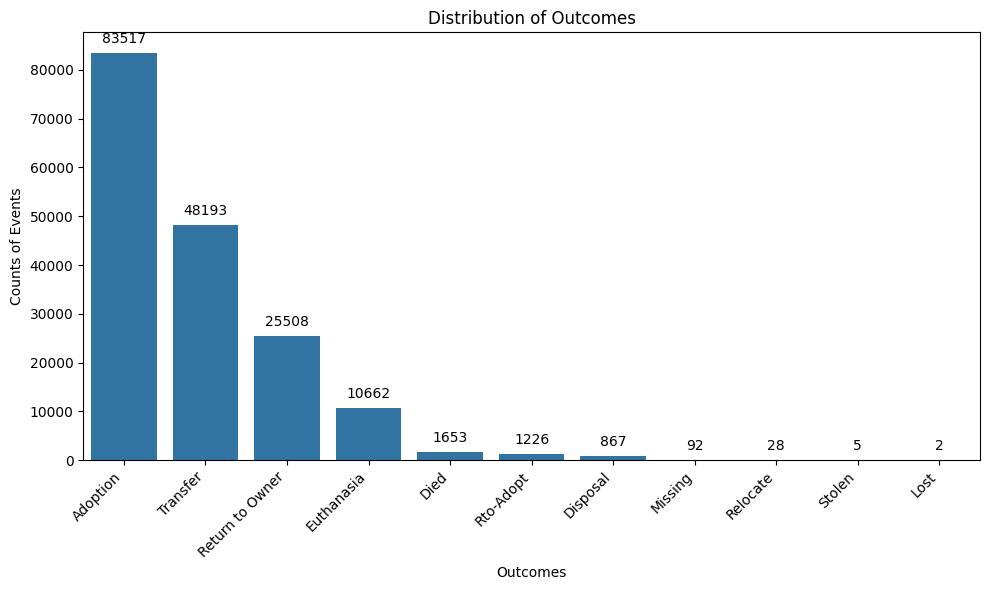

In [26]:
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=outcome_counts.index, y=outcome_counts.values)
plt.xlabel("Outcomes")
plt.ylabel("Counts of Events")
plt.title("Distribution of Outcomes")
plt.xticks(rotation=45, ha='right')

for bar in bars.patches:
    bars.annotate(f'{int(bar.get_height())}',
                   (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                   ha='center', va='bottom',
                   xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

In [12]:
import re

def convert_age_to_days(age_str):
    # Handle negative values
    if pd.isna(age_str) or '-' in age_str:
        return np.nan

    # Extract numerical value and unit
    match = re.match(r"(\d+)\s(\w+)", age_str)
    if match:
        value, unit = int(match.group(1)), match.group(2).lower()

        # Convert to days based on unit
        if 'year' in unit:
            return value * 365
        elif 'month' in unit:
            return value * 30
        elif 'week' in unit:
            return value * 7
        elif 'day' in unit:
            return value
    return np.nan

In [13]:
data['age_days'] = data['age_upon_outcome'].apply(convert_age_to_days)

#Distribution of Age in Days
print(data['age_days'].describe())
print("Negative or NaN Age Days:", data[data['age_days'] <= 0]['age_days'].count())

count    171780.000000
mean        723.614751
std        1022.748279
min           0.000000
25%          60.000000
50%         365.000000
75%         730.000000
max       10950.000000
Name: age_days, dtype: float64
Negative or NaN Age Days: 268


In [16]:
data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], errors='coerce')

data['day_of_birth'] = data['date_of_birth'].dt.day
data['month_of_birth'] = data['date_of_birth'].dt.month
data['year_of_birth'] = data['date_of_birth'].dt.year


In [17]:
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')

data['outcome_event_day'] = data['datetime'].dt.day
data['outcome_event_month'] = data['datetime'].dt.month
data['outcome_event_year'] = data['datetime'].dt.year


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171795 entries, 0 to 171794
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   animal_id            171795 non-null  object        
 1   name                 122637 non-null  object        
 2   datetime             171795 non-null  datetime64[ns]
 3   monthyear            171795 non-null  object        
 4   date_of_birth        171795 non-null  datetime64[ns]
 5   outcome_type         171753 non-null  object        
 6   outcome_subtype      78709 non-null   object        
 7   animal_type          171795 non-null  object        
 8   sex_upon_outcome     171793 non-null  object        
 9   age_upon_outcome     171789 non-null  object        
 10  breed                171795 non-null  object        
 11  color                171795 non-null  object        
 12  age_days             171780 non-null  float64       
 13  day_of_birth  

In [20]:
# Extract Season of Outcome
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Unknown'

data['outcome_event_season'] = data['outcome_event_month'].apply(get_season)

In [21]:
def simplify_sex(sex):
    if sex in ['Neutered Male', 'Spayed Female']:
        return 'Fixed'
    elif sex in ['Intact Male', 'Intact Female']:
        return 'Intact'
    else:
        return 'Unknown'

data['reproductive_status'] = final_df['sex_upon_outcome'].apply(simplify_sex)

In [22]:
# Text Features from Name
data['name_length'] = data['name'].fillna('').apply(len)
data['has_name'] = data['name'].notna().astype(int)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171795 entries, 0 to 171794
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   animal_id             171795 non-null  object        
 1   name                  122637 non-null  object        
 2   datetime              171795 non-null  datetime64[ns]
 3   monthyear             171795 non-null  object        
 4   date_of_birth         171795 non-null  datetime64[ns]
 5   outcome_type          171753 non-null  object        
 6   outcome_subtype       78709 non-null   object        
 7   animal_type           171795 non-null  object        
 8   sex_upon_outcome      171793 non-null  object        
 9   age_upon_outcome      171789 non-null  object        
 10  breed                 171795 non-null  object        
 11  color                 171795 non-null  object        
 12  age_days              171780 non-null  float64       
 13 

In [28]:
# Identify Mix vs Pure
data['breed_type'] = data['breed'].apply(lambda x: 'Mix' if 'Mix' in x else 'Pure')

In [30]:
# Convert to Binary Column
data['is_fixed'] = data['reproductive_status'].apply(lambda x: 1 if x == 'Fixed' else 0)

In [33]:
data['is_weekend'] = data['datetime'].dt.dayofweek >= 5

In [37]:
data['is_weekend'] = data['is_weekend'].astype(int)

In [40]:
data['is_Pure_breed'] = data['breed_type'].apply(lambda x: 1 if x == 'Pure' else 0)

In [41]:
data_transformed = data.copy()

In [43]:
columns_to_drop = [
    'animal_id',        # Unique identifier, not useful for modeling
    'name',             # High cardinality, already encoded as name_length and has_name
    'datetime',         # Extracted into temporal features
    'monthyear',        # Extracted into temporal features
    'date_of_birth',    # Used to calculate age_days and age_group
    'age_upon_outcome', # Transformed into age_days and age_group
    'sex_upon_outcome', # Encoded into is_fixed
    'reproductive_status', # Encoded into is_fixed
    'breed',            # Encoded into breed_type
    'outcome_event_month',    # Redundant with outcome_season
    'outcome_event_day',      # Low predictive power and noise
    'name_length'      # Redundant with has_name
    ]

# Drop all columns in one go
data_transformed.drop(columns=columns_to_drop, inplace=True)

In [48]:
data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171795 entries, 0 to 171794
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   outcome_type          171753 non-null  object 
 1   animal_type           171795 non-null  object 
 2   color                 171795 non-null  object 
 3   age_days              171780 non-null  float64
 4   day_of_birth          171795 non-null  int32  
 5   month_of_birth        171795 non-null  int32  
 6   year_of_birth         171795 non-null  int32  
 7   outcome_event_season  171795 non-null  object 
 8   has_name              171795 non-null  int64  
 9   breed_type            171795 non-null  object 
 10  is_fixed              171795 non-null  int64  
 11  is_weekend            171795 non-null  int64  
 12  is_Pure_breed         171795 non-null  int64  
dtypes: float64(1), int32(3), int64(4), object(5)
memory usage: 15.1+ MB


In [46]:
data_transformed.drop(columns=['outcome_event_year', 'outcome_subtype'], inplace=True)

In [59]:
data_transformed.drop(columns=['breed_type'], inplace=True)

In [49]:
if 'outcome_event_year' in data.columns:
    data_transformed['outcome_event_year'] = data['outcome_event_year']
else:
    print("'outcome_event_year' column not found in 'data'.")


In [63]:
data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171795 entries, 0 to 171794
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   outcome_type          171753 non-null  object 
 1   animal_type           171795 non-null  object 
 2   color                 171795 non-null  object 
 3   age_days              171780 non-null  float64
 4   day_of_birth          171795 non-null  int32  
 5   month_of_birth        171795 non-null  int32  
 6   year_of_birth         171795 non-null  int32  
 7   outcome_event_season  171795 non-null  object 
 8   has_name              171795 non-null  int64  
 9   is_fixed              171795 non-null  int64  
 10  is_weekend            171795 non-null  int64  
 11  is_Pure_breed         171795 non-null  int64  
 12  outcome_event_year    171795 non-null  int32  
dtypes: float64(1), int32(4), int64(4), object(4)
memory usage: 14.4+ MB


In [60]:
data_transformed.head()

,outcome_type,animal_type,color,age_days,day_of_birth,month_of_birth,year_of_birth,outcome_event_season,has_name,is_fixed,is_weekend,is_Pure_breed,outcome_event_year
0,Adoption,Cat,Black/White,90.0,25,3,2023,Summer,1,1,1,0,2023
1,Rto-Adopt,Cat,Brown Tabby/White,730.0,2,5,2017,Spring,1,1,0,0,2019
2,Adoption,Dog,White/Brown,365.0,12,7,2017,Summer,1,1,0,0,2018
3,Euthanasia,Other,Gray,365.0,16,8,2019,Summer,0,0,1,1,2020
4,Adoption,Dog,Buff,120.0,8,10,2015,Winter,1,1,1,1,2016


<ipython-input-54-6885989d0678>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)
<ipython-input-54-6885989d0678>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)
<ipython-input-54-6885989d0678>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)
<ipython-input-54-6885989d0678>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data[col], shade=True)
<ipython-input-54-6885989d0678>:7: FutureWarning: 

`shade` is now deprecated in favor o

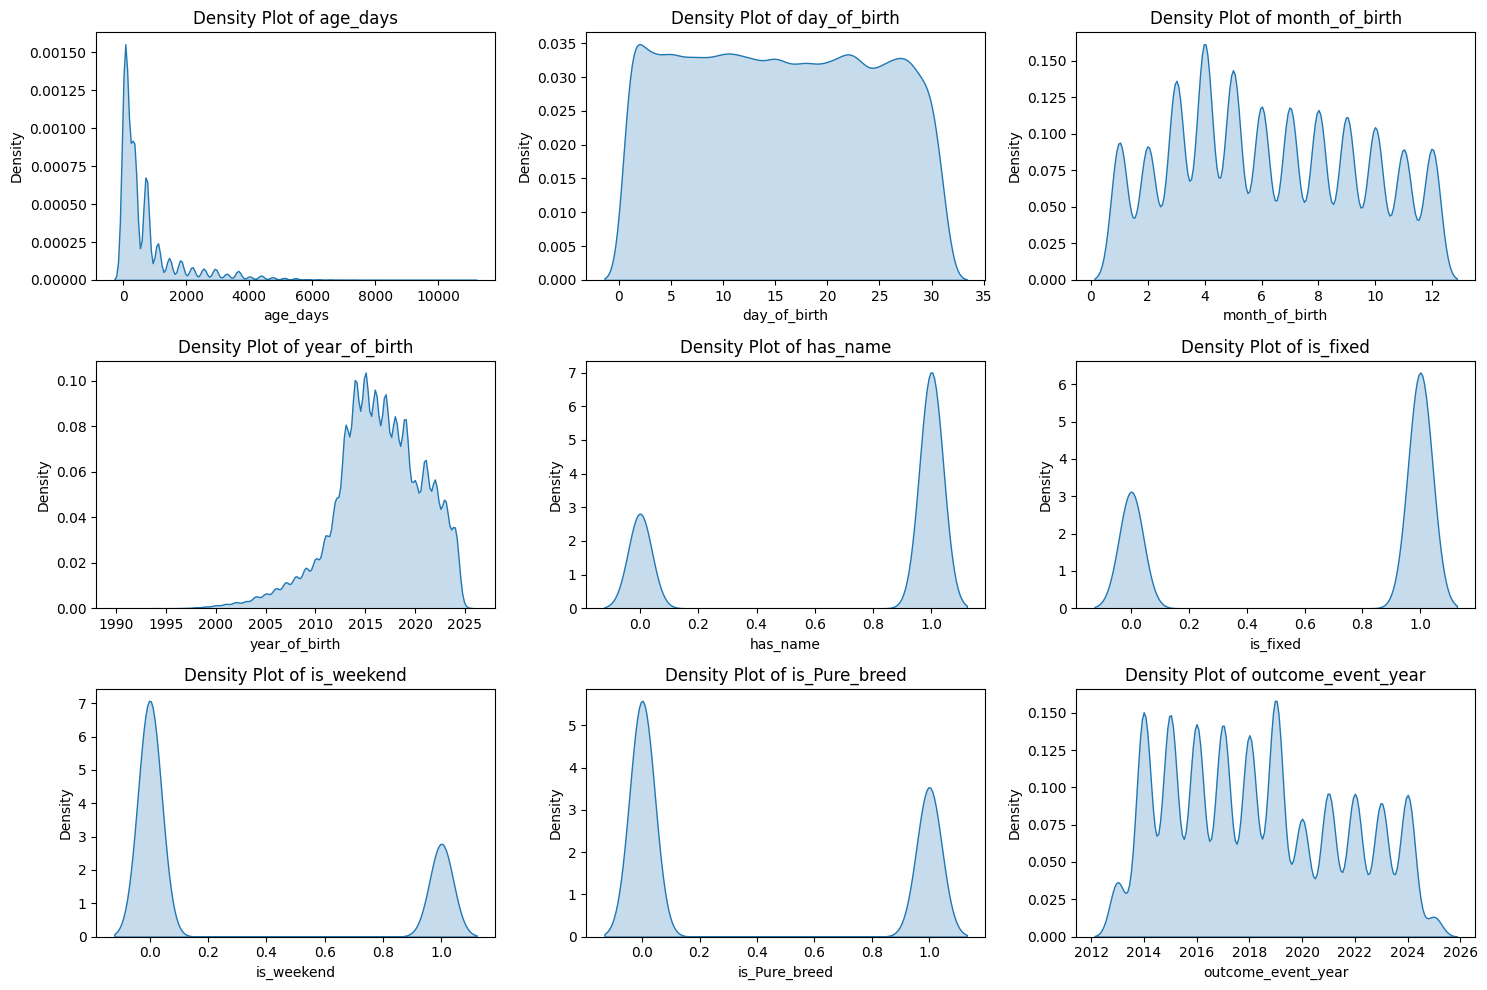

In [54]:
numerical_features = data_transformed.select_dtypes(include=np.number).columns

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i + 1)
    sns.kdeplot(data[col], shade=True)
    plt.title(f'Density Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [53]:
outcome_distribution = data_transformed.groupby(['outcome_event_season', 'outcome_type']).size().unstack(fill_value=0)
outcome_distribution

outcome_type,Adoption,Died,Disposal,Euthanasia,Lost,Missing,Relocate,Return to Owner,Rto-Adopt,Stolen,Transfer
outcome_event_season,,,,,,,,,,,
Fall,21568,378,211,2481,1,22,9,6555,323,0,12710
Spring,16057,436,250,3398,1,17,10,6705,319,3,12158
Summer,24796,593,273,2740,0,34,6,5662,285,2,14460
Winter,21096,246,133,2043,0,19,3,6586,299,0,8865


In [55]:
import plotly.express as px

fig = px.bar(outcome_distribution.reset_index(),
             x='outcome_event_season',
             y=outcome_distribution.columns[1:],  # Exclude the season column
             barmode='group',  # Group for each outcome type
             title='Outcome Distribution by Season',
             labels={'value': 'Count', 'variable': 'Outcome Type', 'outcome_event_season': 'Season'},
             color_discrete_sequence=px.colors.qualitative.Set3)

fig.show()


<Axes: ylabel='count'>

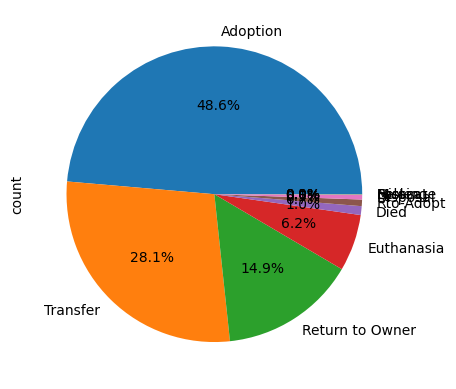

In [56]:
data_transformed["outcome_type"].value_counts().plot.pie(autopct="%1.1f%%")

<Axes: ylabel='count'>

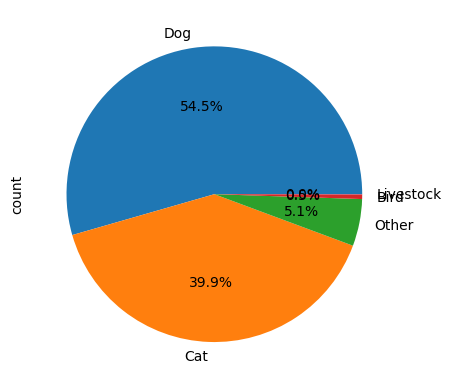

In [57]:
data_transformed["animal_type"].value_counts().plot.pie(autopct="%1.1f%%")

<Axes: ylabel='count'>

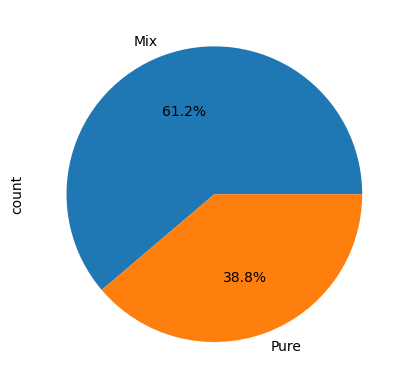

In [58]:
data_transformed["breed_type"].value_counts().plot.pie(autopct="%1.1f%%")

<Axes: ylabel='count'>

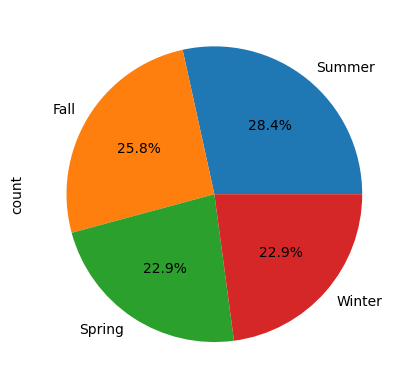

In [62]:
data_transformed["outcome_event_season"].value_counts().plot.pie(autopct="%1.1f%%")

In [64]:
from sklearn.ensemble import IsolationForest

def detect_outliers(df, columns, contamination=0.05):
    """Detects outliers in specified columns using Isolation Forest.

    Args:
        df: The input DataFrame.
        columns: A list of column names to check for outliers.
        contamination: The proportion of outliers in the data set.

    Returns:
        A DataFrame with a new 'outlier' column indicating outliers (1) or inliers (0).
    """

    outlier_indices = []

    for col in columns:
      model = IsolationForest(contamination=contamination, random_state=42)
      model.fit(df[[col]])
      df[f"{col}_outlier"] = model.predict(df[[col]])
      outlier_indices.extend(df[df[f"{col}_outlier"] == -1].index.tolist())

    outlier_indices = list(set(outlier_indices))

    df['outlier'] = 0  # Initialize all rows as inliers
    df.loc[outlier_indices, 'outlier'] = 1  # Mark detected outliers

    return df
numerical_cols = ['age_days', 'day_of_birth', 'month_of_birth', 'year_of_birth', 'outcome_event_year', 'is_fixed', 'is_weekend', 'is_Pure_breed'] # Replace with your numerical column names
data_transformed = detect_outliers(data_transformed, numerical_cols)

print(data_transformed['outlier'].value_counts())

outlier
0    153946
1     17849
Name: count, dtype: int64


In [67]:
data_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171795 entries, 0 to 171794
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   outcome_type                171753 non-null  object 
 1   animal_type                 171795 non-null  object 
 2   color                       171795 non-null  object 
 3   age_days                    171780 non-null  float64
 4   day_of_birth                171795 non-null  int32  
 5   month_of_birth              171795 non-null  int32  
 6   year_of_birth               171795 non-null  int32  
 7   outcome_event_season        171795 non-null  object 
 8   has_name                    171795 non-null  int64  
 9   is_fixed                    171795 non-null  int64  
 10  is_weekend                  171795 non-null  int64  
 11  is_Pure_breed               171795 non-null  int64  
 12  outcome_event_year          171795 non-null  int32  
 13  age_days_outli